# Quantum chemistry on the QLM

The **Variational Quantum Eigensolver** method solves the following minimization problem :
$$
E = \min_{\vec{\theta}}\; \langle \psi(\vec{\theta}) \,|\, \hat{H} \,|\, \psi(\vec{\theta}) \rangle
$$

Here, we use a **Unitary Coupled Cluster** trial state, of the form:
$$
|\psi(\vec{\theta})\rangle = e^{\hat{T}(\vec{\theta}) - \hat{T}^\dagger(\vec{\theta})} |0\rangle
$$
where $\hat{T}(\theta)$ is the *cluster operator*: 
$$
\hat{T}(\vec{\theta}) = \hat{T}_1(\vec{\theta}) + \hat{T}_2(\vec{\theta}) + \cdots
$$
where
$$
\hat{T}_1 = \sum_{a\in U}\sum_{i \in O} \theta_a^i\, \hat{a}_a^\dagger \hat{a}_i \qquad
\hat{T}_2 = \sum_{a>b\in U}\sum_{i>j\in O} \theta_{a, b}^{i, j}\, \hat{a}^\dagger_a \hat{a}^\dagger_b \hat{a}_i \hat{a}_j \qquad
\cdots
$$
($O$ is the set of occupied orbitals and $U$, the set of unoccupied ones.)

## Example: $H_2$ molecule

One has to first describe the geometry and atomic content of the molecule (in this case, $H_2$).

This is done, in the cell below, using the open-source ``pySCF`` package. We specify the chosen basis set and the studied geometry. Here, we chose to study dihydrogen in the so-called STO-3G basis at 0.7414 Angström (internuclear distance.)

In [1]:
import numpy as np

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, verbose=True, run_FCI=True)

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

/usr/local/lib64/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


HF energy= -1.1166843870853405
MP2 energy= -1.1298551535553094
FCI energy= -1.137270174660903
Number of qubits =  4


#### As we will see below, it can be useful to wrap the hamiltonian data into the `MolecularHamiltonian` class.

In [2]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(mol_h)

 MolecularHamiltonian(
 - constant_coeff : 0.7137539936876182
 - integrals shape
    * one_body_integrals : (2, 2)
    * two_body_integrals : (2, 2, 2, 2)



## Computation of cluster operators $T$ and good guess $\vec{\theta}_0$

We now construct the cluster operators (``cluster_ops``) defined in the introduction part as $\hat{T}(\vec{\theta})$, as well as a good starting parameter $\vec{\theta}$ (based on the second order Møller-Plesset perturbation theory).

In [3]:
from qat.fermion.chemistry.ucc import guess_init_params, get_hf_ket, get_cluster_ops

# Computation of the initial parameters
theta_init = guess_init_params(
    mol_h.two_body_integrals,
    n_electrons,
    orbital_energies,
)

print(f"List of initial parameters : {theta_init}")

# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(n_electrons, nqbits=nqbits)

# Compute the cluster operators
cluster_ops = get_cluster_ops(n_electrons, nqbits=nqbits)

List of initial parameters : [0, 0, 0.07265074220469023]


## Encode to qubits: Fermion-spin transformation

All the above operators are fermion operators. We now transform them to spin (or qubit) space. There are different possible choices. Here, we choose the Jordan-Wigner transform (the commented out imports show how to use the other transforms that are available on the QLM).

In [4]:
from qat.fermion.transforms import transform_to_jw_basis  # , transform_to_bk_basis, transform_to_parity_basis
from qat.fermion.transforms import recode_integer, get_jw_code  # , get_bk_code, get_parity_code

# Compute the ElectronicStructureHamiltonian
H = mol_h.get_electronic_hamiltonian()

In [5]:
# Transform the ElectronicStructureHamiltonian into a spin Hamiltonian
H_sp = transform_to_jw_basis(H)

In [6]:
# Express the cluster operator in spin terms
cluster_ops_sp = [transform_to_jw_basis(t_o) for t_o in cluster_ops]

In [7]:
# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, get_jw_code(H_sp.nbqbits))

## Trotterize the Hamiltonian to get the parameterized circuit to optimize

In [8]:
from qat.lang.AQASM import Program, X
from qat.fermion.trotterisation import make_trotterisation_routine

prog = Program()
reg = prog.qalloc(H_sp.nbqbits)

# Initialize the Hartree-Fock state into the Program
for j, char in enumerate(format(hf_init_sp, "0" + str(H_sp.nbqbits) + "b")):
    if char == "1":
        prog.apply(X, reg[j])

# Define the parameters to optimize
theta_list = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(len(cluster_ops))]

# Define the parameterized Hamiltonian
cluster_op = sum([theta * T for theta, T in zip(theta_list, cluster_ops_sp)])

# Trotterize the Hamiltonian (with 1 trotter step)
qrout = make_trotterisation_routine(cluster_op, n_trotter_steps=1, final_time=1)

prog.apply(qrout, reg)
circ = prog.to_circ()

Alternatively, you can simply use the `construct_ucc_ansatz` fonction:

In [9]:
from qat.fermion.chemistry.ucc import construct_ucc_ansatz

prog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = prog.to_circ()

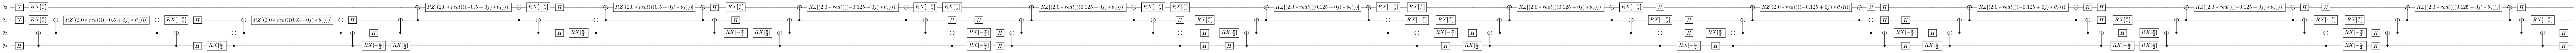

In [10]:
%qatdisplay circ

## Optimize the angles of $\psi(\vec{\theta})$ for a given QPU

We can now use the QLM's variational plugins to perform the VQE optimization.

In [11]:
job = circ.to_job(observable=H_sp, nbshots=0)

from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_init)
qpu = optimizer_scipy | get_default_qpu()
result = qpu.submit(job)

print("Minimum energy =", result.value)

Minimum energy = -1.1372692374939386


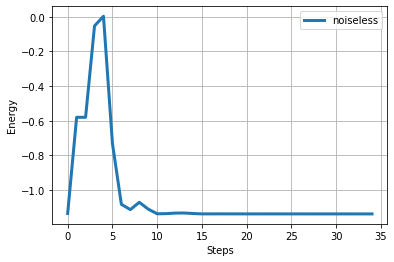

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)

plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## Further questions to be investigated:
- How does this work for a bigger molecule ?
- How to do an active space selection to simplify the computations ?

These questions are answered in our [second example of quantum chemistry computations on an $LiH$ molecule.](vqe_ucc_example_2_lih.ipynb)